In [64]:
from skmap.io import RasterData
from skmap.io import process
from pathlib import Path
from minio import Minio
from eumap.misc import find_files, nan_percentile, ttprint
from eumap.raster import read_rasters, save_rasters
import matplotlib.pyplot as plt

tile = '005W_37N'

files = find_files(f'/mnt/inca/tillage_index/visual_check_tmp/{tile}','skmap_ndvi_*.tif')
files = files[0:30]
data,_ = read_rasters(raster_files=files, n_jobs = 30, verbose=True)
# data = data[0:100,0:100,:]
# data.shape

[16:00:59] Reading 30 raster files using 30 workers


In [84]:
from scipy.signal import find_peaks
import numpy as np
from scipy.signal import savgol_filter

def peaks(ndvi):
    min_height = 0.5*250  # NDVI higher than 0.5 could be seen as a peak
    min_prominence = 0*250  # Minimum prominence is 0.2 (peak must be at least 0.2 more than neibouring troughs)
    min_distance = 1  # 1*2 months, minimum between each peak
    
    peaks, prop = find_peaks(ndvi, height=min_height, prominence=min_prominence, distance=min_distance)
    nos = len(peaks)
    return peaks,prop


def savgol(ndvi):
    window_length = 3
    polyorder = 2
    min_distance = 1

    # Calculate the first derivative of NDVI data using Savitzky-Golay filter
    ndvi_derivative = savgol_filter(ndvi, window_length, polyorder, deriv=2)

    # Find peaks: points where the derivative changes sign from positive to negative
    peaks = np.where(ndvi_derivative < -2)[0] 
#     troughs = np.where(np.diff(np.sign(ndvi_derivative)) == 2)[0] + 1

    min_height = 0.5 * 250  # NDVI higher than 0.5 could be seen as a peak
    # Filter peaks based on height and other criteria if necessary
    peaks = [peak for peak in peaks if ndvi[peak] >= min_height]
    
    merged_peaks = []
    for i in range(len(peaks)):
        if i == 0 or (peaks[i] - peaks[i - 1] > min_distance):
            merged_peaks.append(peaks[i])
        else:
            # Compare the current peak with the last peak in merged_peaks
            if ndvi[peaks[i]] > ndvi[merged_peaks[-1]]:
                # Replace the last peak in merged_peaks with the current one if it's higher
                merged_peaks[-1] = peaks[i]

    return peaks


import matplotlib.pyplot as plt
import time
from scipy.signal import find_peaks, savgol_filter

def benchmark_peaks_methods(pixel, data):
    # Extract the time series data for the given pixel
    time_series = data[pixel[0], pixel[1], :]
#     print(time_series)

    # Time and execute find_peaks
    start_time = time.time()
    fp, prop = peaks(time_series)
    find_peaks_duration = time.time() - start_time

    # Time and execute Savitzky-Golay filter (savgol)
    start_time = time.time()
    # Adjust window_length and polyorder as needed
    sp = savgol(time_series)
    savgol_duration = time.time() - start_time
    print(sp)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(time_series/250, label='Original Time Series')
    plt.plot(sp, time_series[sp]/250, 'yo', label='savitzky-golay Peaks')
    plt.plot(fp, time_series[fp]/250, 'rx', label='find_peaks Peaks')
    plt.legend()
    plt.title('Peak Detection Benchmark')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

    # Print the timing results
    print(f"find_peaks: {find_peaks_duration} seconds")
    print(f"Savitzky-Golay filter: {savgol_duration} seconds")

[0, 1, 7, 10, 13, 16, 19, 22, 25, 28, 29]


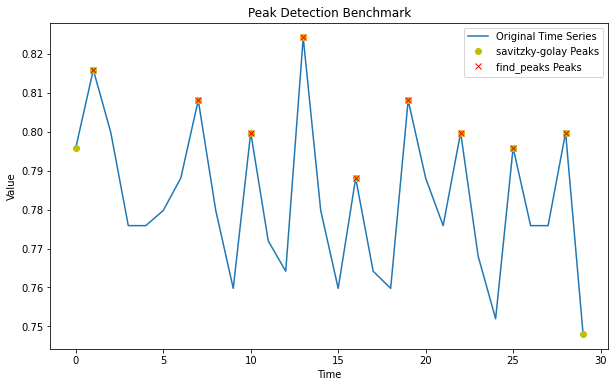

find_peaks: 0.0008947849273681641 seconds
Savitzky-Golay filter: 0.0011565685272216797 seconds


In [85]:
pixel = (3,1)
benchmark_peaks_methods(pixel,data)

[2, 3, 6, 7, 10, 11, 13, 17, 19, 23, 24, 26]


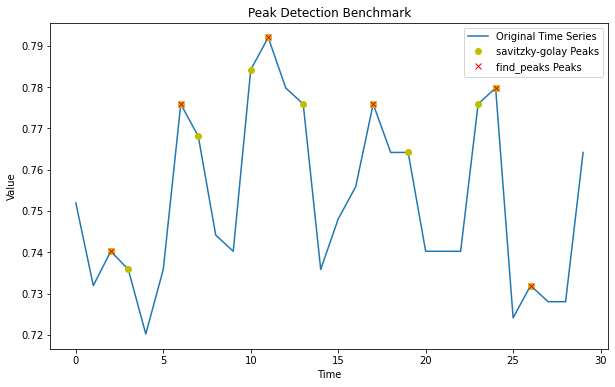

find_peaks: 0.0011866092681884766 seconds
Savitzky-Golay filter: 0.001127004623413086 seconds


In [86]:
pixel = (3,40)
benchmark_peaks_methods(pixel,data)

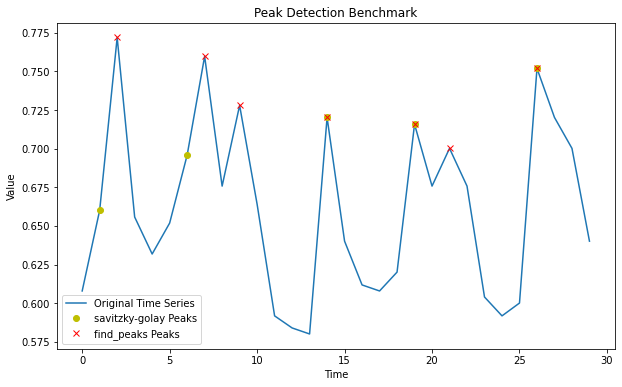

find_peaks: 0.0003287792205810547 seconds
Savitzky-Golay filter: 0.0020143985748291016 seconds


In [71]:
pixel = (2507,2500)
benchmark_peaks_methods(pixel,data)